In [10]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import pandana as pdn
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import warnings
import os
import json

warnings.filterwarnings("ignore")

In [3]:
pois = gpd.read_file('/app/data/input/amenities_costanera_v2')

In [13]:
def load_pandana_network_graph():
    graph = ox.graph_from_place(
        "Concepción, Chile",
        network_type="walk",
        simplify=False,
    )

    nodes_df, edges_df = ox.graph_to_gdfs(graph)
    nodes_df = nodes_df.rename(columns={'x': 'lon', 'y': 'lat'})
    nodes_df['id'] = nodes_df.index
    nodes_df = nodes_df[['id', 'lon', 'lat', 'geometry']]
    edges_df = edges_df.reset_index()
    edges_df['from'] = edges_df.reset_index()['u'].values
    edges_df['to'] = edges_df.reset_index()['v'].values
    edges_df = edges_df[['from', 'to', 'length', 'geometry']]

    net = pdn.Network(
        nodes_df['lon'],
        nodes_df['lat'],
        edges_df['from'],
        edges_df['to'],
        edges_df[['length']]
    )
    return net

net = load_pandana_network_graph()

KeyboardInterrupt: 

In [5]:
grid = gpd.read_file('/app/data/input/grilla')
grid = grid.to_crs(pois.crs)

In [6]:
# Agrega el centroide a la grilla y los puntos (x,y)
grid['centroid'] = grid['geometry'].centroid
grid['x'] = grid['centroid'].x
grid['y'] = grid['centroid'].y

# Agrega los puntos (x,y) de los pois
pois['x'] = pois['geometry'].x
pois['y'] = pois['geometry'].y

In [7]:
grid['nearest_node'] = net.get_node_ids(grid['x'], grid['y'])
pois['nearest_node'] = net.get_node_ids(pois['x'], pois['y'])

In [8]:
n_rank = 3
output_cols = ['grid_id', 'rank', 'origin', 'destination', 'path_lengths', 'Category', 'Subcategor', 'geometry']

categories = pois['Category'].unique()
df_output = []

for category in categories:
    mask = pois['Category']==category
    destination_nodes = pois.loc[mask, 'nearest_node']
    for index, row in grid.iterrows():
        origin_node = row['nearest_node']
        origin_nodes = [origin_node]*len(destination_nodes)
        shortest_path_lengths = net.shortest_path_lengths(origin_nodes, destination_nodes)
        df = pd.DataFrame.from_dict({
            'origin': origin_nodes,
            'destination': destination_nodes,
            'path_lengths': shortest_path_lengths,
        })
        df.sort_values(by='path_lengths', inplace=True)
        df = df.head(n_rank)
        df['grid_id'] = grid.loc[index, 'grid_id']
        df.reset_index(inplace=True, drop=True)
        df['rank'] = df.index + 1
        df = pd.merge(df, pois[mask].rename(columns={'nearest_node': 'destination'}), on='destination')

        df_output.append(df[output_cols])

df_output = pd.concat(df_output)

In [12]:
df_output.drop_duplicates(inplace=True)

In [13]:
df_output.to_pickle('/app/data/output/costanera_amenities_accesibility.pkl')

In [21]:
df_output.columns

Index(['grid_id', 'rank', 'origin', 'destination', 'path_lengths', 'Category',
       'Subcategor', 'geometry'],
      dtype='object')

In [17]:
grid_cols = ['grid_id', 'geometry', 'nearest_node']
grid = grid[grid_cols]

<Axes: >

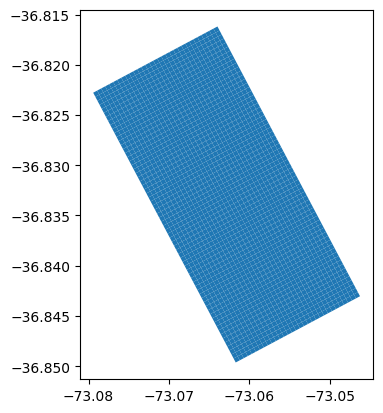

In [19]:
grid.plot()

In [51]:
gdf_output = gpd.GeoDataFrame(data=df_output.drop(columns=['geometry']), geometry=df_output['geometry'])

In [52]:
gdf_output.to_file('/app/data/output/costanera_amenities_accesibility')